# GAN Workflow Engine with the MedNIST Dataset

The MONAI framework can be used to easily design, train, and evaluate generative adversarial networks. This notebook exemplifies using MONAI components to design and train a simple GAN model to reconstruct images of Hand CT scans.

Read the [MONAI Mednist GAN Tutorial](https://github.com/Project-MONAI/MONAI/blob/master/examples/notebooks/mednist_GAN_tutorial.ipynb) for details about the network architecture and loss functions.

**Table of Contents**

1. Load libraries
2. Initialize MONAI Components
    * Create image transform chain
    * Create dataset and dataloader
    * Define generator and discriminator
    * Create training handlers
    * Create GanTrainer
3. Run Training
4. Evaluate Results

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/Project-MONAI/MONAI/blob/master/examples/notebooks/mednist_GAN_workflow.ipynb)

## Step 1: Prepare python libraries and download data

In [ ]:
!pip install monai

In [2]:
import tarfile
from urllib.request import urlopen
from io import BytesIO

import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
import logging
import torch

import monai
from monai.data import CacheDataset, DataLoader, png_writer
from monai.networks.nets import Generator, Discriminator
from monai.networks import normal_init
from monai.engines import GanTrainer
from monai.engines.utils import GanKeys as Keys
from monai.engines.utils import default_make_latent as make_latent
from monai.handlers import StatsHandler, CheckpointSaver, MetricLogger
from monai.transforms import (
    Compose,
    LoadPNGD,
    AddChannelD,
    ScaleIntensityD,
    RandRotateD,
    RandFlipD,
    RandZoomD,
    ToTensorD,
)
from monai.apps.utils import download_and_extract
from monai.utils.misc import set_determinism

In [3]:
monai.config.print_config()

MONAI version: 0.2.0+90.g0a00acc.dirty
Python version: 3.8.3 (default, May 19 2020, 18:47:26)  [GCC 7.3.0]
Numpy version: 1.18.5
Pytorch version: 1.5.0

Optional dependencies:
Pytorch Ignite version: 0.3.0
Nibabel version: 3.1.0
scikit-image version: 0.17.2
Pillow version: 7.1.2
Tensorboard version: 2.2.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



### Get the dataset

MedNIST dataset information in [MONAI MedNIST Tutorial](https://github.com/Project-MONAI/MONAI/blob/master/examples/notebooks/mednist_tutorial.ipynb) example notebook.

In [ ]:
mednist_url = 'https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1'
md5_value = "0bc7306e7427e00ad1c5526a6677552d"
extract_dir = 'data'
tar_save_path = os.path.join(extract_dir, "MedNIST.tar.gz")
download_and_extract(mednist_url, tar_save_path, extract_dir, md5_value)
hand_dir = os.path.join(extract_dir, 'MedNIST', 'Hand')
training_datadict = [{"hand": os.path.join(hand_dir, filename)} for filename in os.listdir(hand_dir)]

In [5]:
print(training_datadict[:5])

[{'hand': 'MedNIST/MedNIST/Hand/004246.jpeg'}, {'hand': 'MedNIST/MedNIST/Hand/004301.jpeg'}, {'hand': 'MedNIST/MedNIST/Hand/006068.jpeg'}, {'hand': 'MedNIST/MedNIST/Hand/005109.jpeg'}, {'hand': 'MedNIST/MedNIST/Hand/004581.jpeg'}]


## Step 2: Initialize MONAI components

In [6]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
set_determinism(12345)
device = torch.device("cuda:0")

### Create image transform chain

Define the processing pipeline to convert saved disk images into usable Tensors.

In [7]:
train_transforms = Compose(
    [
        LoadPNGD(keys=["hand"]),
        AddChannelD(keys=["hand"]),
        ScaleIntensityD(keys=["hand"]),
        RandRotateD(keys=["hand"], range_x=15, prob=0.5, keep_size=True),
        RandFlipD(keys=["hand"], spatial_axis=0, prob=0.5),
        RandZoomD(keys=["hand"], min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensorD(keys=["hand"]),
    ]
)

### Create dataset and dataloader

Hold data and present batches during training.

In [8]:
real_dataset = CacheDataset(training_datadict, train_transforms)

10000/10000 Load and cache transformed data:  [==============================]


In [9]:
batch_size = 300
real_dataloader = DataLoader(real_dataset, batch_size=batch_size, shuffle=True, num_workers=10)
def prepare_batch(batchdata):
    return batchdata["hand"]

### Define generator and discriminator

Load basic computer vision GAN networks from libraries.

In [10]:
# define networks
disc_net = Discriminator(
    in_shape=(1, 64, 64), channels=(8, 16, 32, 64, 1), strides=(2, 2, 2, 2, 1), num_res_units=1, kernel_size=5
).to(device)

latent_size = 64
gen_net = Generator(
    latent_shape=latent_size, start_shape=(latent_size, 8, 8), channels=[32, 16, 8, 1], strides=[2, 2, 2, 1]
)
gen_net.conv.add_module("activation", torch.nn.Sigmoid())
gen_net = gen_net.to(device)

# initialize both networks
disc_net.apply(normal_init)
gen_net.apply(normal_init)

# define optimizors
learning_rate = 2e-4
betas = (0.5, 0.999)
disc_opt = torch.optim.Adam(disc_net.parameters(), learning_rate, betas=betas)
gen_opt = torch.optim.Adam(gen_net.parameters(), learning_rate, betas=betas)

# define loss functions
disc_loss_criterion = torch.nn.BCELoss()
gen_loss_criterion = torch.nn.BCELoss()
real_label = 1
fake_label = 0

def discriminator_loss(gen_images, real_images):
    real = real_images.new_full((real_images.shape[0], 1), real_label)
    gen = gen_images.new_full((gen_images.shape[0], 1), fake_label)

    realloss = disc_loss_criterion(disc_net(real_images), real)
    genloss = disc_loss_criterion(disc_net(gen_images.detach()), gen)

    return (genloss + realloss) / 2

def generator_loss(gen_images):
    output = disc_net(gen_images)
    cats = output.new_full(output.shape, real_label)
    return gen_loss_criterion(output, cats)

### Create training handlers

Perform operations during model training.

In [11]:
run_dir = "hand-gan"

metric_logger = MetricLogger(
        loss_transform=lambda x: {Keys.GLOSS: x[Keys.GLOSS], Keys.DLOSS: x[Keys.DLOSS]},
        metric_transform=lambda x: x 
    )

handlers = [
    StatsHandler(
        name="batch_training_loss",
        output_transform=lambda x: {Keys.GLOSS: x[Keys.GLOSS], Keys.DLOSS: x[Keys.DLOSS]},
    ),
    CheckpointSaver(
        save_dir=run_dir,
        save_dict={"g_net": gen_net, "d_net": disc_net},
        save_interval=10,
        save_final=True,
        epoch_level=True,
    ),
    metric_logger
]

### Create GanTrainer

MONAI Workflow engine for adversarial learning. The components come together here with the GanTrainer.

Uses a training loop based on Goodfellow et al. 2014 https://arxiv.org/abs/1406.266. 

```
Training Loop: for each batch of data size m
        1. Generate m fakes from random latent codes.
        2. Update D with these fakes and current batch reals, repeated d_train_steps times.
        3. Generate m fakes from new random latent codes.
        4. Update generator with these fakes using discriminator feedback.
```

In [12]:
disc_train_steps = 5
num_epochs = 50

trainer = GanTrainer(
    device,
    num_epochs,
    real_dataloader,
    gen_net,
    gen_opt,
    generator_loss,
    disc_net,
    disc_opt,
    discriminator_loss,
    d_prepare_batch=prepare_batch,
    d_train_steps=disc_train_steps,
    g_update_latents=True,
    latent_shape=latent_size,
    key_train_metric=None,
    train_handlers=handlers,
)

INFO:ignite.engine.engine.GanTrainer:Will add AMP support when PyTorch v1.6 released.


## Step 3: Start Training

In [ ]:
trainer.run()

## Evaluate Results

Examine G and D loss curves for collapse.

In [14]:
g_loss = [loss[Keys.GLOSS] for loss in metric_logger.loss]
d_loss = [loss[Keys.DLOSS] for loss in metric_logger.loss]

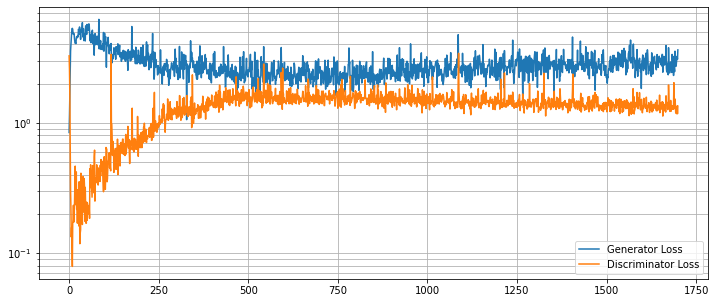

In [15]:
plt.figure(figsize=(12, 5))
plt.semilogy(g_loss, label='Generator Loss')
plt.semilogy(d_loss, label='Discriminator Loss')
plt.grid(True, 'both', 'both')
plt.legend()
plt.show()

### View image reconstructions
With random latent codes view trained generator output.

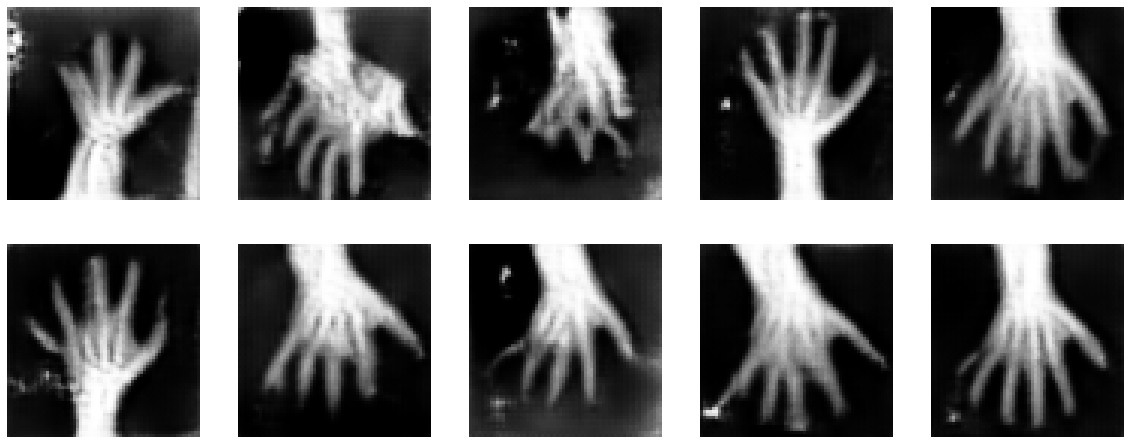

In [16]:
test_img_count = 10
test_latents = make_latent(test_img_count, latent_size).to(device)
fakes = gen_net(test_latents)

fig, axs = plt.subplots(2, (test_img_count//2), figsize=(20, 8))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.axis('off')
    ax.imshow(fakes[i, 0].cpu().data.numpy(), cmap='gray')